# Forecasting Gold Prices using Gated Recurrent Units (GRUs)

## Contents Page

1. Section 1: Introduction
  * Section 1.1: Outline
  * Section 1.2: Loading the Data
2. Section 2: Data Preparation
  * Section 2.1: Duplicate data
  * Section 2.2: Missing values
  * Section 2.3: Outliers
  * Section 2.4: Setting the target variable
  * Section 2.5: Feature selection
  * Section 2.6: Scaling
  * Section 2.7: Splitting the data
3. Section 3: Training and evaluation
  * Section 3.1: Linear regression
  * Section 3.2: GRU

## Section 1: Introduction

Our ML pipeline is the following. Load the data, Clean the data (outliers, duplicates, missing values), split the data into train, test and validation sets, scale the data, train the models, evaluate the models performance on the test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
import my_utils as mu
import torch
from torch.utils import data
from torch import nn
from IPython import display

### Section 1.1: Outline

Section 1 is the intro which loads the data. Section 2 we begin data preparation and derive the variables. Section 3 we carry out exploratory analysis to begin analysing relationships between variables. In Section 4, we carry out our regression to get an accurate measure of the relationships between predictor and target variables.

### Section 1.2: Loading the data

The data is loaded from a CSV file. The date is used as an index in this dataset.

In [3]:
# Loading the dataframe
gold_prices = pd.read_csv('Gold_Historical.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
gold_prices.sort_values(by='Date', inplace=True)
gold_prices = gold_prices.rename(columns={'Close/Last': 'Close'})

# Printing the first 5 rows
gold_prices.head()

,Close,Volume,Open,High,Low
Date,,,,,
2012-06-11,1596.8,109042.0,1602.8,1609.3,1582.8
2012-06-12,1613.8,140522.0,1595.4,1618.8,1587.1
2012-06-13,1619.4,121539.0,1611.1,1625.8,1607.0
2012-06-14,1619.6,132247.0,1619.0,1628.9,1610.5
2012-06-15,1628.1,112994.0,1624.0,1634.5,1620.8


In [4]:
gold_prices.shape

(2551, 5)

## Section 2: Data Preparation

In this section we prepare the data for exploratory analysis. We clean the data and condense it to allow it to be interpreted more smoothly and to reduce the amount of noise that will affect possible patterns that could be identified. Tasks such as merging columns and handling missing values will be conducted.

### Section 2.1: Duplicate data

In [5]:
gold_prices[(gold_prices.duplicated() == True)]
gold_prices = gold_prices.drop_duplicates()

### Section 2.2: Missing values

We need to deal with null or missing values in the dataset. The existence of null values in the dataset causes issues during training since they function as outliers. We need to decide what's the best course of action for the null values as there are multiple ways to deal with them. We also need to understand what they mean as we could be omitting important data points.

In [6]:
print("Dataframe shape: ", gold_prices.shape)
print("Null values present: ", gold_prices.isnull().any())
gold_prices[gold_prices.isnull().any(axis=1)]

gold_prices = gold_prices.dropna()
gold_prices

Dataframe shape:  (2549, 5)
Null values present:  Close     False
Volume     True
Open      False
High      False
Low       False
dtype: bool


,Close,Volume,Open,High,Low
Date,,,,,
2012-06-11,1596.8,109042.0,1602.8,1609.3,1582.8
2012-06-12,1613.8,140522.0,1595.4,1618.8,1587.1
2012-06-13,1619.4,121539.0,1611.1,1625.8,1607.0
2012-06-14,1619.6,132247.0,1619.0,1628.9,1610.5
2012-06-15,1628.1,112994.0,1624.0,1634.5,1620.8
...,...,...,...,...,...
2022-06-03,1850.2,110502.0,1872.6,1878.6,1849.7
2022-06-06,1843.7,95742.0,1853.7,1861.2,1843.0
2022-06-07,1852.1,115125.0,1843.5,1858.2,1838.5


### Section 2.3: Outliers

In [7]:
gold_prices.describe()

,Close,Volume,Open,High,Low
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,1436.640422,180159.045798,1436.647710,1446.100000,1426.834648
std,253.697662,98145.357273,253.851912,255.477046,251.484837
min,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,1244.250000,117423.000000,1244.050000,1251.700000,1235.900000
50%,1319.200000,166626.000000,1320.300000,1328.000000,1311.800000
75%,1682.300000,230055.000000,1679.000000,1695.250000,1666.300000
max,2069.400000,787217.000000,2076.400000,2082.100000,2049.000000


Values lower than the 5th percentile : 33258.0 are considered outliers due to little trading activity


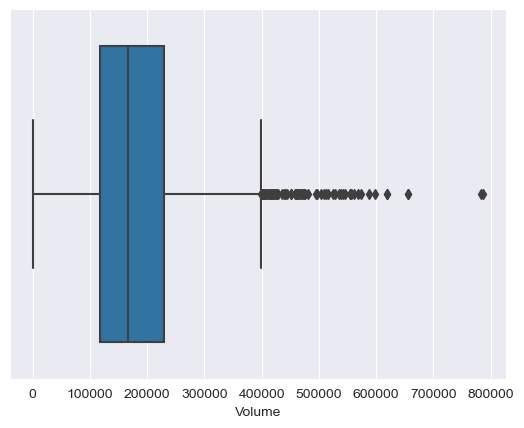

In [8]:
box = sns.boxplot(x=gold_prices.Volume)

# Bottom 5% of values in the dataset 
p = np.percentile(gold_prices.Volume, 5)
p
  
#Outlier boundaries
print('Values lower than the 5th percentile :', p, 'are considered outliers due to little trading activity')

In [9]:
gold_prices.loc[(gold_prices['Volume'] <= p)]

,Close,Volume,Open,High,Low
Date,,,,,
2012-06-21,1565.5,15315.0,1565.5,1565.5,1565.5
2012-07-31,1614.6,6673.0,1614.5,1614.5,1614.5
2012-08-07,1612.8,78.0,1614.7,1615.0,1614.4
2012-10-08,1775.7,1218.0,1777.8,1778.4,1775.8
2013-05-09,1468.6,8501.0,1468.6,1468.6,1468.6
...,...,...,...,...,...
2020-05-22,1734.6,6.0,1726.6,1726.7,1726.6
2020-05-29,1736.9,1406.0,1718.8,1738.3,1715.1
2021-03-18,1734.6,18942.0,1745.9,1756.0,1719.1


In [10]:
# Drops outliers. 
gold_prices.drop(gold_prices[gold_prices.Volume <= p].index, inplace=True)

gold_prices

,Close,Volume,Open,High,Low
Date,,,,,
2012-06-11,1596.8,109042.0,1602.8,1609.3,1582.8
2012-06-12,1613.8,140522.0,1595.4,1618.8,1587.1
2012-06-13,1619.4,121539.0,1611.1,1625.8,1607.0
2012-06-14,1619.6,132247.0,1619.0,1628.9,1610.5
2012-06-15,1628.1,112994.0,1624.0,1634.5,1620.8
...,...,...,...,...,...
2022-06-03,1850.2,110502.0,1872.6,1878.6,1849.7
2022-06-06,1843.7,95742.0,1853.7,1861.2,1843.0
2022-06-07,1852.1,115125.0,1843.5,1858.2,1838.5


In [11]:
gold_prices.describe()

,Close,Volume,Open,High,Low
count,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000
mean,1436.569224,189407.353040,1436.765493,1446.237610,1426.739161
std,256.636514,91825.966831,256.919300,258.422918,254.518685
min,1049.600000,33301.000000,1051.500000,1062.700000,1045.400000
25%,1243.400000,125318.000000,1242.800000,1250.800000,1235.100000
50%,1317.800000,170463.000000,1318.000000,1325.300000,1309.600000
75%,1694.000000,233796.000000,1695.700000,1708.300000,1683.000000
max,2069.400000,787217.000000,2076.400000,2082.100000,2049.000000


### Section 2.4: Setting the Target Variable (Close price)

* The Close Value is the final output value that will be forecasted using the Machine Learning models. This figure indicates the stock’s closing price on that particular day of stock market trading. This is assigned to the target variable.

In [12]:
#Set Target Variable
gold_prices = gold_prices.rename(columns={'Close': 'Target'})
gold_prices

,Target,Volume,Open,High,Low
Date,,,,,
2012-06-11,1596.8,109042.0,1602.8,1609.3,1582.8
2012-06-12,1613.8,140522.0,1595.4,1618.8,1587.1
2012-06-13,1619.4,121539.0,1611.1,1625.8,1607.0
2012-06-14,1619.6,132247.0,1619.0,1628.9,1610.5
2012-06-15,1628.1,112994.0,1624.0,1634.5,1620.8
...,...,...,...,...,...
2022-06-03,1850.2,110502.0,1872.6,1878.6,1849.7
2022-06-06,1843.7,95742.0,1853.7,1861.2,1843.0
2022-06-07,1852.1,115125.0,1843.5,1858.2,1838.5


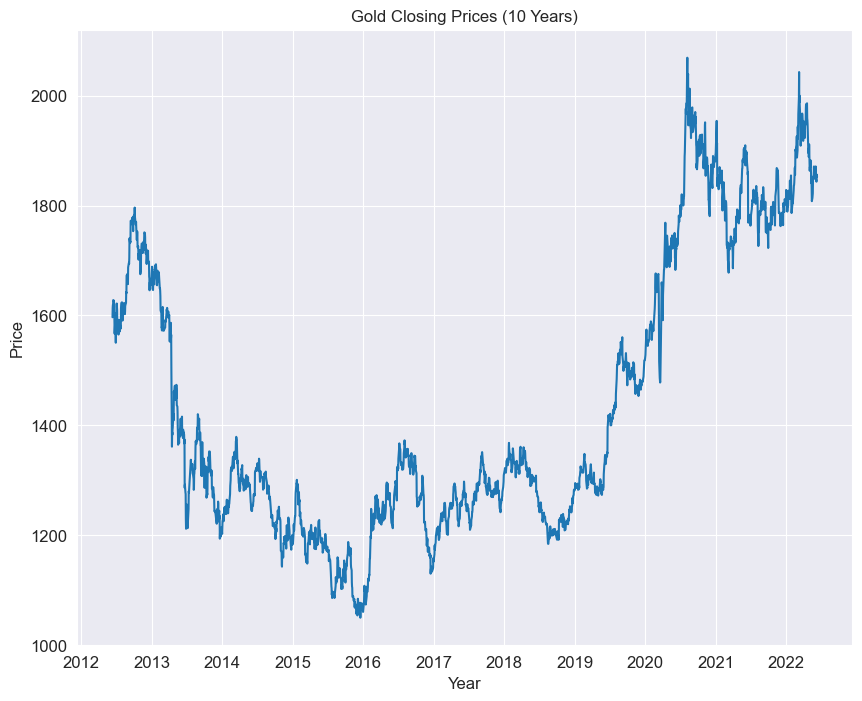

In [13]:
# Visualisation of the target variable (Close price)
fig, (a1) = plt.subplots(1, 1, figsize=(10, 8))
a1.set_title('Gold Closing Prices (10 Years)',fontsize=12)
a1.plot(gold_prices.Target)
a1.set_ylabel('Price', fontsize=12)
a1.set_xlabel('Year', fontsize=12)

a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=12)

### Section 2.5: Feature selection

* We will be creating a new feature called daily volatility. This along with open price will be the two features used to predict the closing price. Daily volatility is calculated using (high-low)/open as a proxy. The open, high and low are highly correlated so may be telling us similar information.

In [14]:
# Daily volatility 
gold_prices['Daily Volatility'] = ((gold_prices['High'] - gold_prices['Low']) / gold_prices['Open'])
gold_prices = gold_prices.drop(columns = ['High','Low'])

In [15]:
# Previous close
gold_prices['Previous Close'] = gold_prices['Target'].shift()
gold_prices = gold_prices.dropna()

In [16]:
# Previous open
gold_prices['Previous Open'] = gold_prices['Open'].shift()
gold_prices = gold_prices.dropna()

In [17]:
gold_prices

,Target,Volume,Open,Daily Volatility,Previous Close,Previous Open
Date,,,,,,
2012-06-13,1619.4,121539.0,1611.1,0.011669,1613.8,1595.4
2012-06-14,1619.6,132247.0,1619.0,0.011365,1619.4,1611.1
2012-06-15,1628.1,112994.0,1624.0,0.008436,1619.6,1619.0
2012-06-18,1627.0,113625.0,1606.9,0.015060,1628.1,1624.0
2012-06-19,1623.2,115240.0,1627.3,0.009894,1627.0,1606.9
...,...,...,...,...,...,...
2022-06-03,1850.2,110502.0,1872.6,0.015433,1871.4,1849.9
2022-06-06,1843.7,95742.0,1853.7,0.009818,1850.2,1872.6
2022-06-07,1852.1,115125.0,1843.5,0.010686,1843.7,1853.7


In [18]:
# Close price percentage change 
gold_prices['Price Change'] = ((gold_prices['Target'] - gold_prices['Open']) / gold_prices['Open'])

In [19]:
# Previous close price percentage change
gold_prices['Previous Change'] = ((gold_prices['Previous Close'] - gold_prices['Previous Open']) / gold_prices['Previous Open'])

In [20]:
gold_prices

,Target,Volume,Open,Daily Volatility,Previous Close,Previous Open,Price Change,Previous Change
Date,,,,,,,,
2012-06-13,1619.4,121539.0,1611.1,0.011669,1613.8,1595.4,0.005152,0.011533
2012-06-14,1619.6,132247.0,1619.0,0.011365,1619.4,1611.1,0.000371,0.005152
2012-06-15,1628.1,112994.0,1624.0,0.008436,1619.6,1619.0,0.002525,0.000371
2012-06-18,1627.0,113625.0,1606.9,0.015060,1628.1,1624.0,0.012509,0.002525
2012-06-19,1623.2,115240.0,1627.3,0.009894,1627.0,1606.9,-0.002520,0.012509
...,...,...,...,...,...,...,...,...
2022-06-03,1850.2,110502.0,1872.6,0.015433,1871.4,1849.9,-0.011962,0.011622
2022-06-06,1843.7,95742.0,1853.7,0.009818,1850.2,1872.6,-0.005395,-0.011962
2022-06-07,1852.1,115125.0,1843.5,0.010686,1843.7,1853.7,0.004665,-0.005395


In [21]:
gold_prices['Target'] = gold_prices['Price Change']

In [22]:
gold_prices = gold_prices.drop(columns = ['Previous Close','Previous Open','Price Change'])

In [23]:
gold_prices

,Target,Volume,Open,Daily Volatility,Previous Change
Date,,,,,
2012-06-13,0.005152,121539.0,1611.1,0.011669,0.011533
2012-06-14,0.000371,132247.0,1619.0,0.011365,0.005152
2012-06-15,0.002525,112994.0,1624.0,0.008436,0.000371
2012-06-18,0.012509,113625.0,1606.9,0.015060,0.002525
2012-06-19,-0.002520,115240.0,1627.3,0.009894,0.012509
...,...,...,...,...,...
2022-06-03,-0.011962,110502.0,1872.6,0.015433,0.011622
2022-06-06,-0.005395,95742.0,1853.7,0.009818,-0.011962
2022-06-07,0.004665,115125.0,1843.5,0.010686,-0.005395


### Section 2.6: Scaling

In [24]:
#Training
scaler = MinMaxScaler()
gold_prices_scaled = scaler.fit_transform(gold_prices)
gold_prices_scaled = pd.DataFrame(columns=gold_prices.columns, data=gold_prices_scaled, index=gold_prices.index)
gold_prices_scaled.head()

,Target,Volume,Open,Daily Volatility,Previous Change
Date,,,,,
2012-06-13,0.537431,0.117040,0.546004,0.128899,0.597499
2012-06-14,0.492426,0.131243,0.553713,0.125409,0.537431
2012-06-15,0.512702,0.105705,0.558591,0.091779,0.492426
2012-06-18,0.606681,0.106542,0.541907,0.167833,0.512702
2012-06-19,0.465221,0.108685,0.561811,0.108516,0.606681


In [25]:
gold_prices = gold_prices_scaled

### Section 2.7: Splitting the dataset

In [26]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

* We will divide our data set into training and test sets. The subset of the population used is the training set which will train the model. The model will then be used to make predictions on the test set. The predictions will then be compared with the actual values in the test set to evaluate the performance of the trained model.

* We will be testing how well the first 7 years can predict the next 3 years. Our test dataset will be used to compare the ground truth values to the predicted values from the model.

* The first 7 years of daily data will be used as our training set nd the last 3 years will be used as a test set. The following script divides the data into training and test sets.

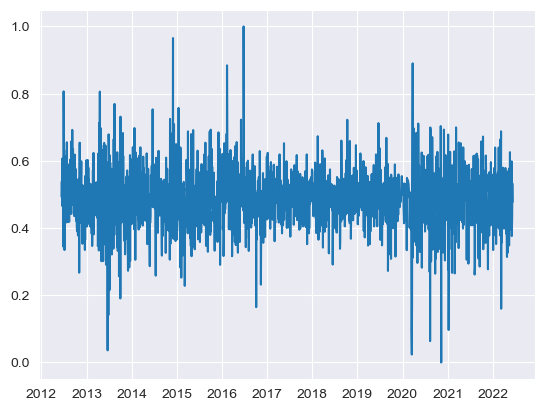

In [27]:
# Plotting target for training
plt.plot(gold_prices['Target'])

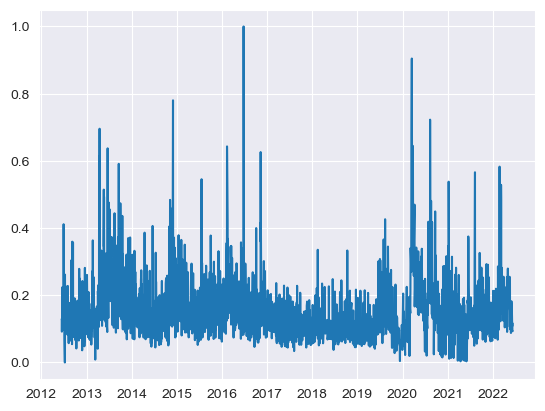

In [28]:
# Plotting intra day volatility
plt.plot(gold_prices['Daily Volatility'])

In [29]:
train = gold_prices['2012-01-01':'2016-12-31'] # Train set, trained model generates predictions for the target variable.
validation = gold_prices['2017-01-01':'2019-12-31'] # Validation set, used for hyperparameter tuning.
test = gold_prices['2020-01-01':'2022-06-09'] # Test set, used to evaluate performance of our trained model.
print('Training set:', train.shape)
print('Validation set', validation.shape)
print('Test set:', test.shape)

Training set: (1115, 5)
Validation set (690, 5)
Test set: (578, 5)


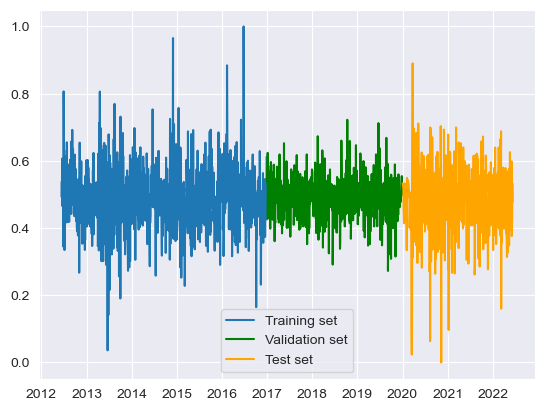

In [30]:
# Plotting true values of train and test.
plt.plot(train.Target, label='Training set')
plt.plot(validation.Target, label='Validation set', color='green')
plt.plot(test.Target, label='Test set', color='orange')
plt.legend();

In [31]:
X_train = train.drop(columns = 'Target')
y_train = train.Target

X_valid = validation.drop(columns = 'Target')
y_valid = validation.Target

X_test = test.drop(columns = 'Target')
y_test = test.Target

In [32]:
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(1115, 4) (690, 4) (578, 4) (1115,) (690,) (578,)


## Section 3: Training and evaluation

### 3.1: Linear regression

In [33]:
import math, time

In [34]:
start = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
stop = time.time()

In [35]:
# calculate mean squared error
predict_train = lr.predict(X_train)
trainScore_lr = mean_squared_error(y_train, predict_train, squared=False)
print('Train Score: %.3f RMSE' % (trainScore_lr))
predict_valid = lr.predict(X_valid)
validScore_lr = mean_squared_error(y_valid, predict_valid, squared=False)
print('Validation Score: %.3f RMSE' % (validScore_lr))
predict_test = lr.predict(X_test)
testScore_lr = mean_squared_error(y_test, predict_test, squared=False)
print('Test Score: %.3f RMSE' % (testScore_lr))

Train Score: 0.084 RMSE
Validation Score: 0.063 RMSE
Test Score: 0.099 RMSE


In [36]:
# calculate mean absolute error
train_mae_lr = mean_absolute_error(y_train, predict_train)
print('Train Score: %.3f MAE' % (train_mae_lr))
valid_mae_lr = mean_absolute_error(y_valid, predict_valid)
print('Validation Score: %.3f MAE' % (valid_mae_lr))
test_mae_lr = mean_absolute_error(y_test, predict_test)
print('Test Score: %.3f MAE' % (test_mae_lr))

Train Score: 0.061 MAE
Validation Score: 0.050 MAE
Test Score: 0.073 MAE


In [37]:
# calculate r2
train_r2_lr = r2_score(y_train, predict_train)
print('Train Score: %.3f r2' % (train_r2_lr))
valid_r2_lr = r2_score(y_valid, predict_valid)
print('Validation Score: %.3f r2' % (valid_r2_lr))
test_r2_lr = r2_score(y_test, predict_test)
print('Test Score: %.3f r2' % (test_r2_lr))

Train Score: 0.030 r2
Validation Score: -0.237 r2
Test Score: -0.107 r2


In [38]:
training_time_lr = round((stop - start),2)
print(f"Training time: {training_time_lr}s")

Training time: 0.0s


### Section 3.2: GRU

We essentially choose the amount of time steps from the previous data we want to include in to the model. We can choose only the previous day / year or the last 3 days etc to influence the gradient of the current time step. time step, batch size and number of features is the tensor for the design matrix

#### Data processing 

In [39]:
#Process the data for GRU
X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_valid = np.array(X_valid).reshape(X_valid.shape[0], 1, X_valid.shape[1])
X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

In [40]:
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(1115, 1, 4) (690, 1, 4) (578, 1, 4) (1115,) (690,) (578,)


In [41]:
# Creating tensors for training
X_train = torch.tensor(X_train.astype(np.float32))
y_train_numpy = y_train
y_train = torch.tensor(y_train.astype(np.float32))
y_train = y_train.unsqueeze(1)

# Creating tensors for validation
X_valid = torch.tensor(X_valid.astype(np.float32))
y_valid_numpy = y_valid
y_valid = torch.tensor(y_valid.astype(np.float32))
y_valid = y_valid.unsqueeze(1)
                    
# Creating tensors for testing
X_test = torch.tensor(X_test.astype(np.float32))
y_test_numpy = y_test
y_test = torch.tensor(y_test.astype(np.float32))
y_test = y_test.unsqueeze(1)

In [42]:
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

torch.Size([1115, 1, 4]) torch.Size([690, 1, 4]) torch.Size([578, 1, 4]) torch.Size([1115, 1]) torch.Size([690, 1]) torch.Size([578, 1])


In [43]:
import torch.utils.data as data_utils

# Passing to DataLoader
train_dataset = data.TensorDataset(X_train, y_train) #TensorDataset object
print(train_dataset[0]) #First example in our dataset. Inputs and output.

(tensor([[0.1170, 0.5460, 0.1289, 0.5975]]), tensor([0.5374]))


#### Defining the model

In [44]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

#### Training and prediction

In [45]:
def train_gru(batch_size, lr, num_epochs, hidden_dim, num_layers):
    train_iter = data.DataLoader(train_dataset, batch_size, shuffle=False) #DataLoader object
    # Double checking our data loader is in the right dimensions.
    train_features, train_labels = next(iter(train_iter))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    input_dim = X_train.shape[-1]
    output_dim = y_train.shape[-1]

    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    loss = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr)

    hist = np.zeros(num_epochs)
    # start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        for X, y in train_iter:
            y_hat = model(X)

            l = loss(y_hat, y)
            hist[epoch] = l.item()

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

        l = loss(model(X_train), y_train)


        model.eval()
        predict_train = model(X_train)
        predict_train = pd.DataFrame(predict_train.detach().numpy())
        trainScore = mean_squared_error(y_train_numpy, predict_train, squared=False)
        predict_valid = model(X_valid)
        predict_valid = pd.DataFrame(predict_valid.detach().numpy())
        validScore = mean_squared_error(y_valid_numpy, predict_valid, squared=False)
        print(f'epoch {epoch + 1}, loss {l:f} Train RMSE Score: {trainScore:.2f},  Valid RMSE Score: {validScore:.2f}')
    return model, validScore, hist
    
# training_time = time.time()-start_time    
# print("Training time: {}".format(training_time))

In [46]:
# hidden_dim = 5
# num_layers = 2
# lr = 0.25

num_epochs = 20
best_score = float('inf')
best_params = None
best_model = None
best_hist = None
start_time = time.time()

for batch_size in [128, 256]:
    for lr in [0.01, 0.1]:
        for hidden_dim in [20, 40, 60, 80, 100]:
            for num_layers in [2, 4, 20, 80]:
                params = dict(batch_size=batch_size, lr=lr, num_epochs=num_epochs, hidden_dim=hidden_dim, num_layers=num_layers)
                print("Trying", params)
                model, validScore, hist = train_gru(**params)
                if validScore < best_score:
                    print("New best model", params)
                    best_score = validScore
                    best_params = params
                    best_model = model
                    best_hist = hist

Trying {'batch_size': 128, 'lr': 0.01, 'num_epochs': 20, 'hidden_dim': 20, 'num_layers': 2}
Feature batch shape: torch.Size([128, 1, 4])
Labels batch shape: torch.Size([128, 1])
epoch 1, loss 0.014748 Train RMSE Score: 0.12,  Valid RMSE Score: 0.12
epoch 2, loss 0.008125 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 3, loss 0.011012 Train RMSE Score: 0.10,  Valid RMSE Score: 0.08
epoch 4, loss 0.010593 Train RMSE Score: 0.10,  Valid RMSE Score: 0.09
epoch 5, loss 0.008457 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 6, loss 0.007416 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 7, loss 0.007290 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 8, loss 0.007298 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 9, loss 0.007284 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.007273 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 11, loss 0.007254 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 12, loss 0.007245 Train RMSE Scor

epoch 3, loss 0.007792 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 4, loss 0.007382 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 5, loss 0.007254 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 6, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 7, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 8, loss 0.007224 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 9, loss 0.007229 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.007219 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 11, loss 0.007219 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 12, loss 0.007219 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 13, loss 0.007216 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 14, loss 0.007214 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 15, loss 0.007211 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 16, loss 0.007207 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06

epoch 4, loss 0.007244 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 5, loss 0.007236 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 6, loss 0.007299 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 7, loss 0.007370 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 8, loss 0.007438 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 9, loss 0.007497 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.007538 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 11, loss 0.007560 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 12, loss 0.007564 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 13, loss 0.007558 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 14, loss 0.007547 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 15, loss 0.007536 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 16, loss 0.007528 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 17, loss 0.007524 Train RMSE Score: 0.09,  Valid RMSE Score: 0.0

epoch 7, loss 0.007226 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 8, loss 0.007286 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 9, loss 0.007309 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.007388 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 11, loss 0.007239 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 12, loss 0.007228 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 13, loss 0.007236 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 14, loss 0.007245 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 15, loss 0.007233 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 16, loss 0.007233 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 17, loss 0.007239 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 18, loss 0.007240 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 19, loss 0.007240 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 20, loss 0.007241 Train RMSE Score: 0.09,  Valid RMSE Score: 

epoch 10, loss 0.007441 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 11, loss 0.007248 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 12, loss 0.007245 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 13, loss 0.007218 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 14, loss 0.007220 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 15, loss 0.007213 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 16, loss 0.007214 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 17, loss 0.007212 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 18, loss 0.007209 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 19, loss 0.007206 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 20, loss 0.007204 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
Trying {'batch_size': 128, 'lr': 0.1, 'num_epochs': 20, 'hidden_dim': 20, 'num_layers': 4}
Feature batch shape: torch.Size([128, 1, 4])
Labels batch shape: torch.Size([128, 1])
epoch 1, loss 0.055195 Train RM

epoch 13, loss 0.007607 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 14, loss 0.007594 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 15, loss 0.007584 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 16, loss 0.007578 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 17, loss 0.007574 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 18, loss 0.007569 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 19, loss 0.007564 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 20, loss 0.007556 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
Trying {'batch_size': 128, 'lr': 0.1, 'num_epochs': 20, 'hidden_dim': 40, 'num_layers': 20}
Feature batch shape: torch.Size([128, 1, 4])
Labels batch shape: torch.Size([128, 1])
epoch 1, loss 0.015303 Train RMSE Score: 0.12,  Valid RMSE Score: 0.11
epoch 2, loss 0.014747 Train RMSE Score: 0.12,  Valid RMSE Score: 0.10
epoch 3, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 4, loss 0.008102 Train RMSE

epoch 16, loss 0.007226 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 17, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 18, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 19, loss 0.007226 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 20, loss 0.007226 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
Trying {'batch_size': 128, 'lr': 0.1, 'num_epochs': 20, 'hidden_dim': 60, 'num_layers': 80}
Feature batch shape: torch.Size([128, 1, 4])
Labels batch shape: torch.Size([128, 1])
epoch 1, loss 0.012929 Train RMSE Score: 0.11,  Valid RMSE Score: 0.10
epoch 2, loss 0.007856 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 3, loss 0.007232 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 4, loss 0.007309 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 5, loss 0.007256 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 6, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 7, loss 0.007230 Train RMSE Sc

epoch 19, loss 0.007311 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 20, loss 0.007297 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
Trying {'batch_size': 128, 'lr': 0.1, 'num_epochs': 20, 'hidden_dim': 100, 'num_layers': 2}
Feature batch shape: torch.Size([128, 1, 4])
Labels batch shape: torch.Size([128, 1])
epoch 1, loss 0.416389 Train RMSE Score: 0.65,  Valid RMSE Score: 0.64
epoch 2, loss 0.077711 Train RMSE Score: 0.28,  Valid RMSE Score: 0.27
epoch 3, loss 0.025399 Train RMSE Score: 0.16,  Valid RMSE Score: 0.15
epoch 4, loss 0.029584 Train RMSE Score: 0.17,  Valid RMSE Score: 0.16
epoch 5, loss 0.007885 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 6, loss 0.011336 Train RMSE Score: 0.11,  Valid RMSE Score: 0.09
epoch 7, loss 0.007303 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 8, loss 0.007831 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 9, loss 0.007280 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.007302 Train RMSE Scor

epoch 5, loss 0.008546 Train RMSE Score: 0.09,  Valid RMSE Score: 0.07
epoch 6, loss 0.007433 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 7, loss 0.007742 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 8, loss 0.007457 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 9, loss 0.007305 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.007269 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 11, loss 0.007294 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 12, loss 0.007271 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 13, loss 0.007230 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 14, loss 0.007224 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 15, loss 0.007246 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 16, loss 0.007231 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 17, loss 0.007223 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 18, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.

epoch 8, loss 0.007320 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 9, loss 0.007234 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.007239 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 11, loss 0.007246 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 12, loss 0.007235 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 13, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 14, loss 0.007235 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 15, loss 0.007230 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 16, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 17, loss 0.007232 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 18, loss 0.007228 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 19, loss 0.007228 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 20, loss 0.007230 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
Trying {'batch_size': 256, 'lr': 0.01, 'num_epochs': 20, 'hidden_d

epoch 11, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 12, loss 0.007238 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 13, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 14, loss 0.007237 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 15, loss 0.007226 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 16, loss 0.007229 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 17, loss 0.007228 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 18, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 19, loss 0.007229 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 20, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
Trying {'batch_size': 256, 'lr': 0.01, 'num_epochs': 20, 'hidden_dim': 80, 'num_layers': 2}
Feature batch shape: torch.Size([256, 1, 4])
Labels batch shape: torch.Size([256, 1])
epoch 1, loss 0.073883 Train RMSE Score: 0.27,  Valid RMSE Score: 0.26
epoch 2, loss 0.041106 Train RM

epoch 15, loss 0.007133 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 16, loss 0.007128 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 17, loss 0.007152 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 18, loss 0.007118 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 19, loss 0.007118 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
epoch 20, loss 0.007113 Train RMSE Score: 0.08,  Valid RMSE Score: 0.06
Trying {'batch_size': 256, 'lr': 0.01, 'num_epochs': 20, 'hidden_dim': 100, 'num_layers': 4}
Feature batch shape: torch.Size([256, 1, 4])
Labels batch shape: torch.Size([256, 1])
epoch 1, loss 0.018699 Train RMSE Score: 0.14,  Valid RMSE Score: 0.12
epoch 2, loss 0.009885 Train RMSE Score: 0.10,  Valid RMSE Score: 0.08
epoch 3, loss 0.007569 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 4, loss 0.007481 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 5, loss 0.007967 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 6, loss 0.007901 Train RMSE 

epoch 18, loss 0.007231 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 19, loss 0.007226 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 20, loss 0.007229 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
Trying {'batch_size': 256, 'lr': 0.1, 'num_epochs': 20, 'hidden_dim': 20, 'num_layers': 20}
Feature batch shape: torch.Size([256, 1, 4])
Labels batch shape: torch.Size([256, 1])
epoch 1, loss 0.086781 Train RMSE Score: 0.29,  Valid RMSE Score: 0.29
epoch 2, loss 0.008288 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 3, loss 0.007539 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 4, loss 0.008997 Train RMSE Score: 0.09,  Valid RMSE Score: 0.07
epoch 5, loss 0.009811 Train RMSE Score: 0.10,  Valid RMSE Score: 0.08
epoch 6, loss 0.007964 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 7, loss 0.007233 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 8, loss 0.007672 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 9, loss 0.007391 Train RMSE Scor

epoch 1, loss 1.030813 Train RMSE Score: 1.02,  Valid RMSE Score: 1.01
epoch 2, loss 0.018937 Train RMSE Score: 0.14,  Valid RMSE Score: 0.12
epoch 3, loss 0.008715 Train RMSE Score: 0.09,  Valid RMSE Score: 0.07
epoch 4, loss 0.009845 Train RMSE Score: 0.10,  Valid RMSE Score: 0.08
epoch 5, loss 0.007241 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 6, loss 0.008326 Train RMSE Score: 0.09,  Valid RMSE Score: 0.07
epoch 7, loss 0.007494 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 8, loss 0.007375 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 9, loss 0.007297 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.007295 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 11, loss 0.007325 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 12, loss 0.007227 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 13, loss 0.007237 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 14, loss 0.007228 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
e

epoch 4, loss 0.012182 Train RMSE Score: 0.11,  Valid RMSE Score: 0.07
epoch 5, loss 0.009609 Train RMSE Score: 0.10,  Valid RMSE Score: 0.07
epoch 6, loss 0.009163 Train RMSE Score: 0.10,  Valid RMSE Score: 0.06
epoch 7, loss 0.009734 Train RMSE Score: 0.10,  Valid RMSE Score: 0.07
epoch 8, loss 0.008320 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 9, loss 0.007970 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.008031 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 11, loss 0.007767 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 12, loss 0.007720 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 13, loss 0.007723 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 14, loss 0.007652 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 15, loss 0.007603 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 16, loss 0.007610 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 17, loss 0.007579 Train RMSE Score: 0.09,  Valid RMSE Score: 0.0

epoch 9, loss 0.008126 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 10, loss 0.009528 Train RMSE Score: 0.10,  Valid RMSE Score: 0.08
epoch 11, loss 0.009287 Train RMSE Score: 0.10,  Valid RMSE Score: 0.07
epoch 12, loss 0.008917 Train RMSE Score: 0.09,  Valid RMSE Score: 0.07
epoch 13, loss 0.008173 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 14, loss 0.007888 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 15, loss 0.007548 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 16, loss 0.007469 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 17, loss 0.007337 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 18, loss 0.007322 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 19, loss 0.007264 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
epoch 20, loss 0.007262 Train RMSE Score: 0.09,  Valid RMSE Score: 0.06
Trying {'batch_size': 256, 'lr': 0.1, 'num_epochs': 20, 'hidden_dim': 100, 'num_layers': 20}
Feature batch shape: torch.Size([256, 1, 4])

In [47]:
training_time_gru = time.time()-start_time    
print("Training time: {}".format(training_time_gru))

Training time: 1158.2801756858826


In [48]:
best_params

{'batch_size': 128,
 'lr': 0.01,
 'num_epochs': 20,
 'hidden_dim': 100,
 'num_layers': 4}

In [49]:
model.eval()
predict_train = best_model(X_train)
predict_train = pd.DataFrame(predict_train.detach().numpy())

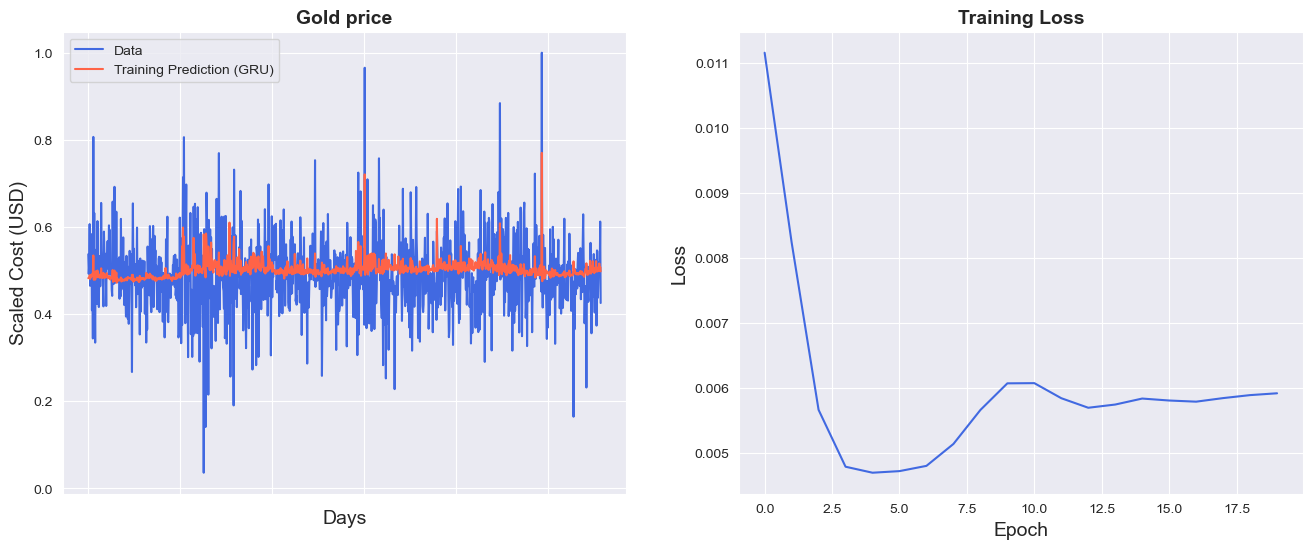

In [50]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = range(len(y_train_numpy)), y = y_train_numpy, label="Data", color='royalblue')
ax = sns.lineplot(x = predict_train.index, y = predict_train[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Gold price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Scaled Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=best_hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

#### Validation set

In [51]:
predict_valid = best_model(X_valid)
predict_valid = pd.DataFrame(predict_valid.detach().numpy())

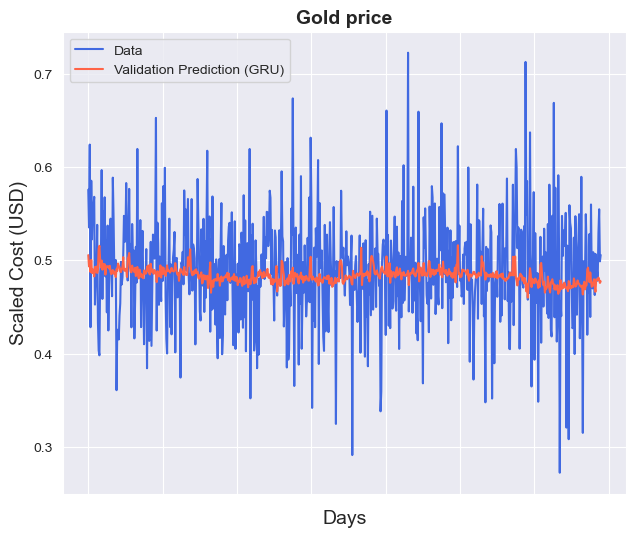

In [52]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = range(len(y_valid_numpy)), y = y_valid_numpy, label="Data", color='royalblue')
ax = sns.lineplot(x = predict_valid.index, y = predict_valid[0], label="Validation Prediction (GRU)", color='tomato')
ax.set_title('Gold price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Scaled Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)

#### GRU prediction

Now that we have our model ready, we can use it to forecast the Close Value of Gold by using a model trained using the GRU network on the test set. This is accomplished by employing the model predict function on the GRU model that has been created.

In [53]:
# Generate predictions
predict_test = best_model(X_test)
predict_test = pd.DataFrame(predict_test.detach().numpy())

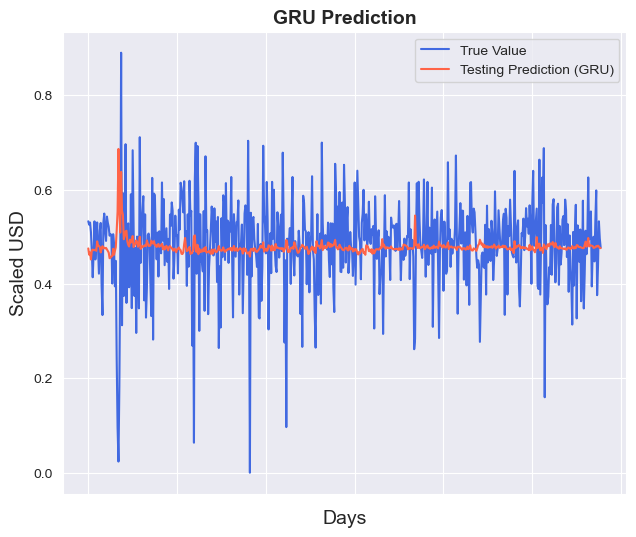

In [54]:
#Predicted vs True Close Value – GRU
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = range(len(y_test_numpy)), y = y_test_numpy, label="True Value", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (GRU)", color='tomato')
ax.set_title('GRU Prediction', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Scaled USD", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)

In [55]:
import math, time
from sklearn.metrics import mean_squared_error

# calculate root mean squared error
trainScore_gru = mean_squared_error(y_train_numpy, predict_train, squared=False)
print('Train Score: %.3f RMSE' % (trainScore_gru))
validScore_gru = mean_squared_error(y_valid_numpy, predict_valid, squared=False)
print('Validation Score: %.3f RMSE' % (validScore_gru))
testScore_gru = mean_squared_error(y_test_numpy, predict_test, squared=False)
print('Test Score: %.3f RMSE' % (testScore_gru))

Train Score: 0.084 RMSE
Validation Score: 0.057 RMSE
Test Score: 0.098 RMSE


In [56]:
# calculate mean absolute error
train_mae_gru = mean_absolute_error(y_train_numpy, predict_train)
print('Train Score: %.3f MAE' % (train_mae_gru))
valid_mae_gru = mean_absolute_error(y_valid_numpy, predict_valid)
print('Validation Score: %.3f MAE' % (valid_mae_gru))
test_mae_gru = mean_absolute_error(y_test_numpy, predict_test)
print('Test Score: %.3f MAE' % (test_mae_gru))

Train Score: 0.061 MAE
Validation Score: 0.043 MAE
Test Score: 0.070 MAE


In [57]:
# calculate r2
train_r2_gru = r2_score(y_train_numpy, predict_train)
print('Train Score: %.3f r2' % (train_r2_gru))
valid_r2_gru = r2_score(y_valid_numpy, predict_valid)
print('Validation Score: %.3f r2' % (valid_r2_gru))
test_r2_gru = r2_score(y_test_numpy, predict_test)
print('Test Score: %.3f r2' % (test_r2_gru))

Train Score: 0.032 r2
Validation Score: 0.011 r2
Test Score: -0.076 r2


In [58]:
#Training results
lr = pd.DataFrame([trainScore_lr, train_mae_lr, train_r2_lr, training_time_lr], columns=['LR'])

gru = pd.DataFrame([trainScore_gru, train_mae_gru, train_r2_gru, training_time_gru], columns=['GRU'])

result = pd.concat([lr, gru], axis=1, join='inner')
result.index = ['Train RMSE','Train MAE','Train r2','Train time']
result = round(result,2)

In [59]:
#Validation results
lr1 = pd.DataFrame([validScore_lr, valid_mae_lr, valid_r2_lr], columns=['LR'])

gru1 = pd.DataFrame([validScore_gru, valid_mae_gru, valid_r2_gru], columns=['GRU'])

result1 = pd.concat([lr1, gru1], axis=1, join='inner')
result1.index = ['Validation RMSE', 'Validation MAE', 'Validation r2']
result1 = round(result1,2)

In [60]:
#Test results
lr2 = pd.DataFrame( [testScore_lr, test_mae_lr, test_r2_lr], columns=['LR'])

gru2 = pd.DataFrame([testScore_gru, test_mae_gru, test_r2_gru], columns=['GRU'])

result2 = pd.concat([lr2, gru2], axis=1, join='inner')
result2.index = ['Test RMSE', 'Test MAE', 'Test r2']
result2 = round(result2,2)

In [61]:
result

,LR,GRU
Train RMSE,0.08,0.08
Train MAE,0.06,0.06
Train r2,0.03,0.03
Train time,0.00,1158.28


In [62]:
result1

,LR,GRU
Validation RMSE,0.06,0.06
Validation MAE,0.05,0.04
Validation r2,-0.24,0.01


In [63]:
result2

,LR,GRU
Test RMSE,0.10,0.10
Test MAE,0.07,0.07
Test r2,-0.11,-0.08
